# Severstal : Steel Defect Detection
https://www.kaggle.com/c/severstal-steel-defect-detection/data

Learning U Nets with Tensorflow using Severstal Dataset from Keggle competition

In [425]:
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import os, sys
import csv
from matplotlib import pyplot as plt
import PIL
from IPython.display import clear_output

In [2]:
test_path = 'test_images'
train_path = 'train_images'

In [3]:
def get_filenames(mypath): 
    return [mypath + '/' + f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

In [4]:
test_filenames = get_filenames(test_path)
train_filenames = get_filenames(train_path) 

In [360]:
print("number of test images:", len(test_filenames))

number of test images: 1801


In [403]:
train_size = len(train_filenames)
print("number of training images:", train_size)

number of training images: 12568


Get training labels / annotations

In [363]:
defects_df = pd.read_csv('train.csv')
defects_df['ImageId'] = defects_df['ImageId_ClassId'].apply(lambda x : x.split('_')[0])
defects_df['ClassId'] = defects_df['ImageId_ClassId'].apply(lambda x : x.split('_')[1])

In [364]:
defects_df.set_index('ImageId_ClassId', inplace=True)

In [365]:
defects_df.head(5)

,EncodedPixels,ImageId,ClassId
ImageId_ClassId,,,
0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1
0002cc93b.jpg_2,NaN,0002cc93b.jpg,2
0002cc93b.jpg_3,NaN,0002cc93b.jpg,3
0002cc93b.jpg_4,NaN,0002cc93b.jpg,4
00031f466.jpg_1,NaN,00031f466.jpg,1


## Training example data

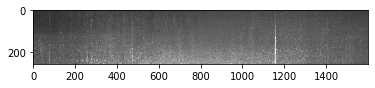

In [11]:
img = cv2.imread(train_path + '/' + defects_df.loc['0007a71bf.jpg_3', 'ImageId'])
plt.imshow(img)

In [23]:
img[0]

array([[47, 47, 47],
       [49, 49, 49],
       [49, 49, 49],
       ...,
       [65, 65, 65],
       [67, 67, 67],
       [63, 63, 63]], dtype=uint8)

https://www.kaggle.com/titericz/building-and-visualizing-masks

Run-length encoding (RLE) is a very simple form of lossless data compression in which runs of data (sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run. 

In [16]:
'''
This function is an rle to mask converter.
You supply the rle string for one mask, along with it's height and width
from the solutions for stage1 and it will return the mask.
'''
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )

In [14]:
img.shape

(256, 1600, 3)

In [17]:
rleToMask = rle2mask(str(defects_df.loc['0007a71bf.jpg_3', 'EncodedPixels']), img.shape)

In [18]:
print(rleToMask.shape)

(256, 1600)


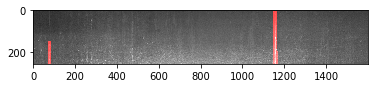

In [19]:
img[rleToMask==1,0] = 255
plt.imshow(img)

## Number of defects per class

In [23]:
defects_df['EncodedPixels'].notnull()

ImageId_ClassId
0002cc93b.jpg_1     True
0002cc93b.jpg_2    False
0002cc93b.jpg_3    False
0002cc93b.jpg_4    False
00031f466.jpg_1    False
                   ...  
ffff4eaa8.jpg_4    False
ffffd67df.jpg_1    False
ffffd67df.jpg_2    False
ffffd67df.jpg_3     True
ffffd67df.jpg_4    False
Name: EncodedPixels, Length: 50272, dtype: bool

In [24]:
defects_df[['ClassId', 'EncodedPixels']][defects_df['EncodedPixels'].notnull()].groupby(['ClassId']).count()

,EncodedPixels
ClassId,
1,897
2,247
3,5150
4,801


Most common deffect class is 3, then 1, followed by 4 and 2

Are there images with multiple defects? 

In [25]:
image_by_defects = defects_df[['ImageId', 'EncodedPixels']][defects_df['EncodedPixels'].notnull()].groupby(['ImageId']).count().sort_values('EncodedPixels', ascending=False)

In [26]:
image_by_defects.head()

,EncodedPixels
ImageId,
ef24da2ba.jpg,3
db4867ee8.jpg,3
84865746c.jpg,2
5665ada1b.jpg,2
eb44ad79d.jpg,2


## Example of an image with 3 defect classes

In [368]:
image = 'ef24da2ba.jpg' 
df_ = defects_df[defects_df['ImageId'] == image]
df_.head()

,EncodedPixels,ImageId,ClassId
ImageId_ClassId,,,
ef24da2ba.jpg_1,366699 32 366955 32 367210 33 367466 33 367722...,ef24da2ba.jpg,1
ef24da2ba.jpg_2,366338 17 366594 50 366850 82 367106 99 367362...,ef24da2ba.jpg,2
ef24da2ba.jpg_3,178369 64 178498 191 178690 255 178946 255 179...,ef24da2ba.jpg,3
ef24da2ba.jpg_4,NaN,ef24da2ba.jpg,4


In [369]:
# 1 - red, 
# 2 - yellow,
# 3- green , 
# 4 - blue
colors = {0: [0, 0, 0], 1 : [255, 0, 0], 2: [255, 255, 0], 3: [0, 255, 0], 4: [0, 0, 255]}

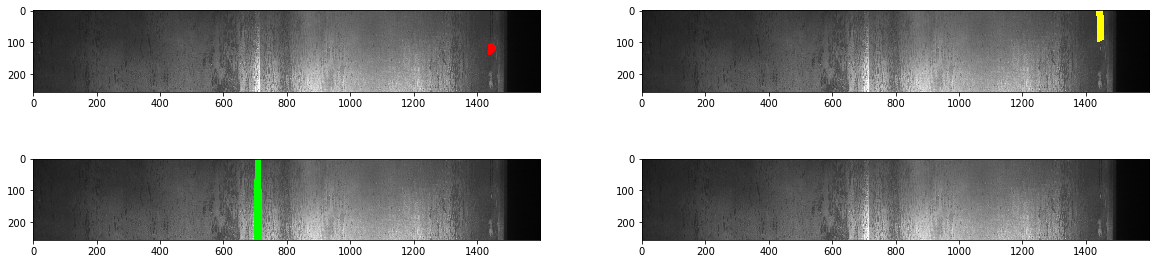

In [370]:
rows=2
columns=2
fig=plt.figure(figsize=(20, 5))
for c_id in range(1, 4+1):
    fig.add_subplot(rows, columns, c_id)
    img = cv2.imread(train_path + '/' + image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    encoded_pixels = df_.loc['{0}_{1}'.format(image, c_id), 'EncodedPixels']
    if str(encoded_pixels) != 'nan':
        rleToMask = rle2mask(encoded_pixels, img.shape)
        img[rleToMask==1] = colors[c_id]
    plt.imshow(img) 
plt.show()

Some more examples

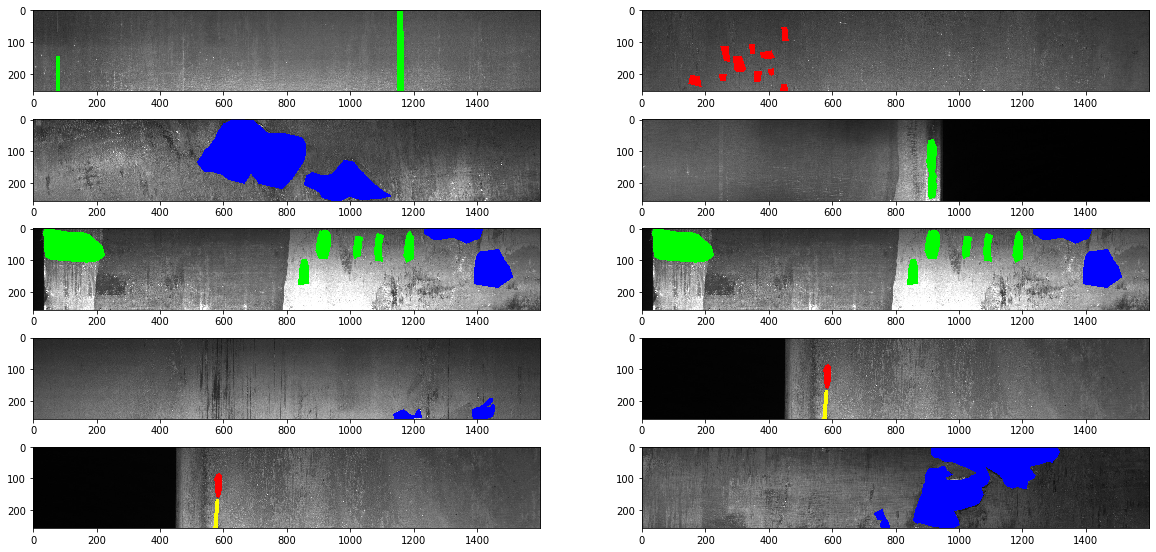

In [23]:
fig=plt.figure(figsize=(20,100))
columns = 2
rows = 50
train = defects_df[defects_df['EncodedPixels'].notnull()]
for i in range(1, 10+1):
    fig.add_subplot(rows, columns, i)
    
    fn = train['ImageId'].iloc[i]
    img = cv2.imread( 'train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    df = train[train['ImageId'] == fn].reset_index()
    for j in range(len(df)):
        mask = rle2mask( df['EncodedPixels'].iloc[j], img.shape  )
        img[mask==1] = colors[int(df['ClassId'].iloc[j])]
    
    plt.imshow(img)
plt.show()

In [372]:
## Unique images with defects
print('Unique images with defects')
no_defects = defects_df[defects_df['EncodedPixels'].notnull()]
len(no_defects['ImageId'].unique())

Unique images with defects


6666

In [29]:
len(defects_df['ImageId'].unique())

12568

## Training Data preparation 
https://www.tensorflow.org/tutorials/load_data/images

In [373]:
## apply the annotations for training data and save masked images to .png in separate folder

In [376]:
img_files = defects_df['ImageId'].unique()
# img_files = img_files[0:10] # for testing

In [201]:
masks = []
for image in img_files:
    #find defects for given image
    img = cv2.imread( 'train_images/'+image )
    #initialize image mask
    masked_images = np.zeros((img.shape[0], img.shape[1], 1))
    df = no_defects[no_defects['ImageId'] == image].reset_index()
    for j in range(len(df)):
        mask = rle2mask( df['EncodedPixels'].iloc[j], img.shape  )
        masked_images[mask==1, 0] = [int(df['ClassId'].iloc[j])]
    cv2.imwrite( f'train_masks/{image}'.replace('jpg', 'png'), masked_images)


Check sample mask

In [379]:
test = cv2.imread('train_masks/0002cc93b.png')

In [380]:
test.shape

(256, 1600, 3)

In [381]:
test[120, 120]

array([0, 0, 0], dtype=uint8)

In [382]:
np.unique(test)

array([0, 1], dtype=uint8)

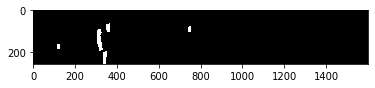

In [385]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(test))

In [386]:
img_to_array = tf.keras.preprocessing.image.array_to_img(test)

In [387]:
type(img_to_array)

PIL.Image.Image

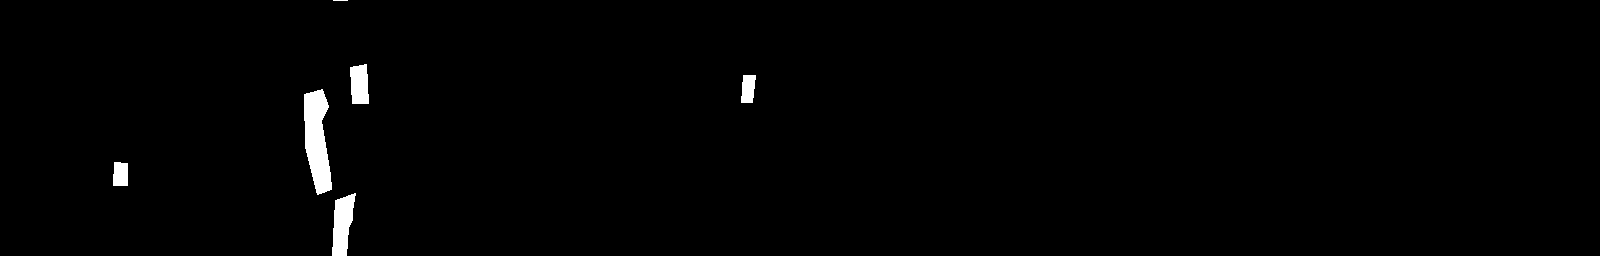

In [388]:
img_to_array

Initialize test and training datasets from folders

In [389]:
list_ds = tf.data.Dataset.list_files('train_images/*.jpg')
test_ds = tf.data.Dataset.list_files('test_images/*.jpg')

In [297]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [390]:
def get_mask_filepath(file_path):
    parts = tf.strings.split(file_path, '/')
    npy_filename = tf.strings.join([tf.constant('train_masks/'), tf.strings.regex_replace(parts[1], 'jpg', 'png')])
    return npy_filename


In [391]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    #input_mask -= 1
    return input_image, input_mask

In [392]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [393]:
def decode_mask(mask):
#     mask = tf.strings.to_number(mask, out_type=tf.dtypes.float32)
    mask = tf.io.decode_png(mask, channels = 1)
#     mask = tf.image.convert_image_dtype(mask, tf.float32)
    return tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])

In [394]:
def process_path(file_path):
    #mask = tf.io.read_file(get_npy_filepath(file_path))
    #mask = decode_mask(mask)
    #mask = tf.cast(mask, 'int32')
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    img = tf.cast(img, tf.float32) / 255.0
    print(get_npy_filepath(file_path))
    mask = tf.io.read_file(get_mask_filepath(file_path))
    mask = decode_mask(mask)
    img, mask = normalize(img, mask)
    return img, mask
    #, mask

In [395]:
for f in list_ds.take(1):
    print(f)
    print(get_npy_filepath(f))

tf.Tensor(b'train_images/fff02e9c5.jpg', shape=(), dtype=string)
tf.Tensor(b'train_masks/fff02e9c5.png', shape=(), dtype=string)


In [396]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
image_ds = list_ds.map(lambda x: process_path(x), num_parallel_calls=AUTOTUNE)


Tensor("StringJoin:0", shape=(), dtype=string)


In [397]:
image_ds.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))

### Slice and split the image dataset into train and dev 
https://www.tensorflow.org/datasets/splits

Split the dataset to train and dev

In [410]:
TRAIN_LENGTH = np.math.floor(train_size * 0.95)
DEV_LENGTH = train_size - TRAIN_LENGTH

In [411]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [412]:
TRAIN_LENGTH, DEV_LENGTH, STEPS_PER_EPOCH

(11939, 629, 186)

In [417]:
image_ds = image_ds.shuffle(BUFFER_SIZE)
train_ds = image_ds.take(TRAIN_LENGTH)
dev_dataset = image_ds.skip(DEV_LENGTH)


In [418]:
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [419]:
dev_dataset = dev_dataset.batch(BATCH_SIZE)

## Image segmentation with U-Net

In [420]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
#         print(type(display_list[i]))
#         print(display_list[i].shape)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
#         plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

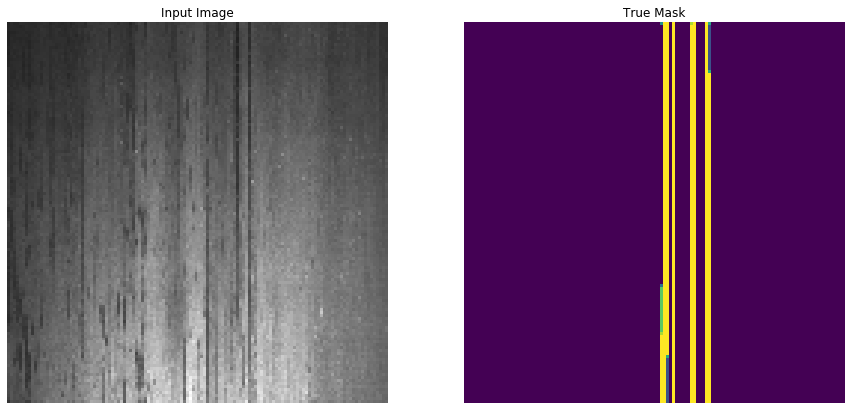

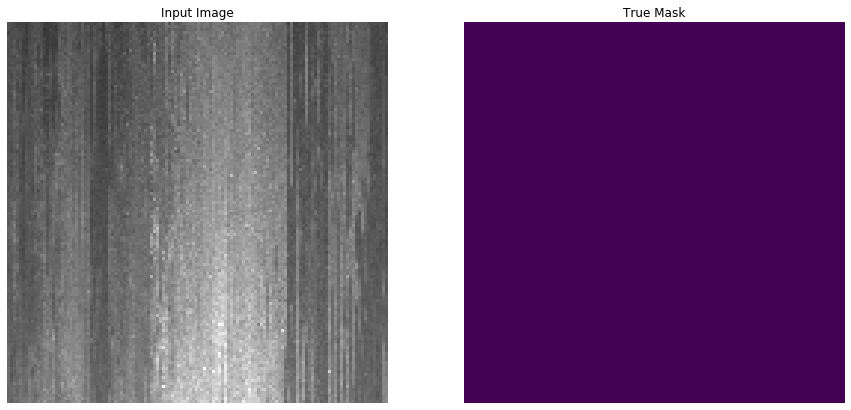

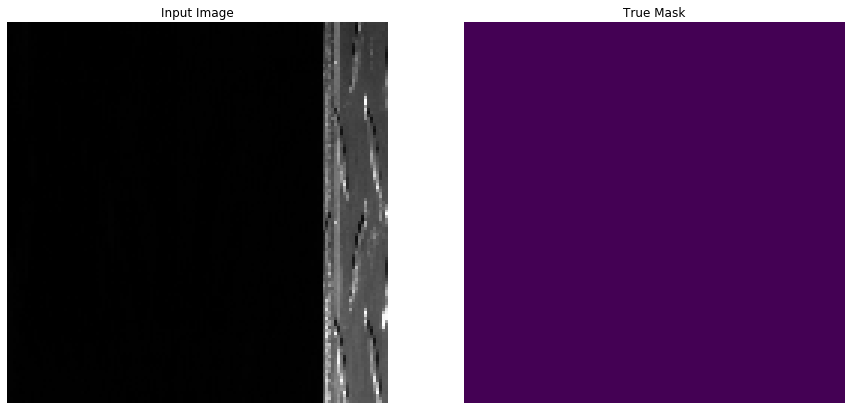

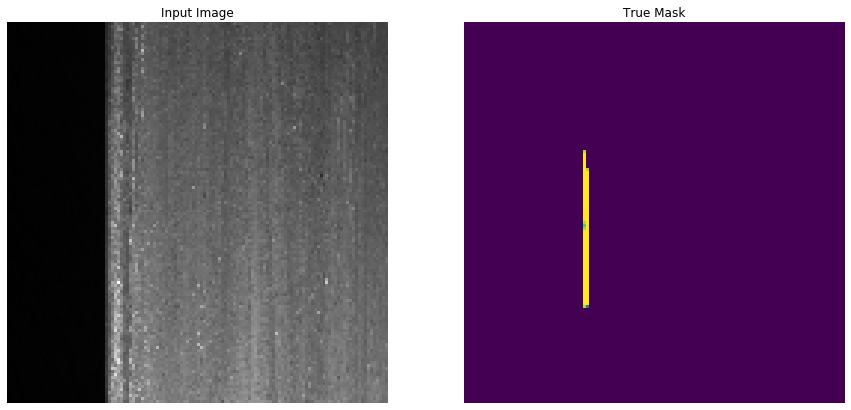

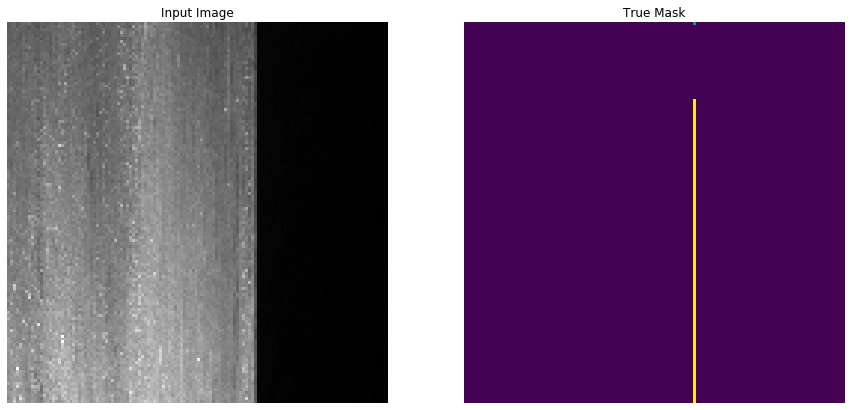

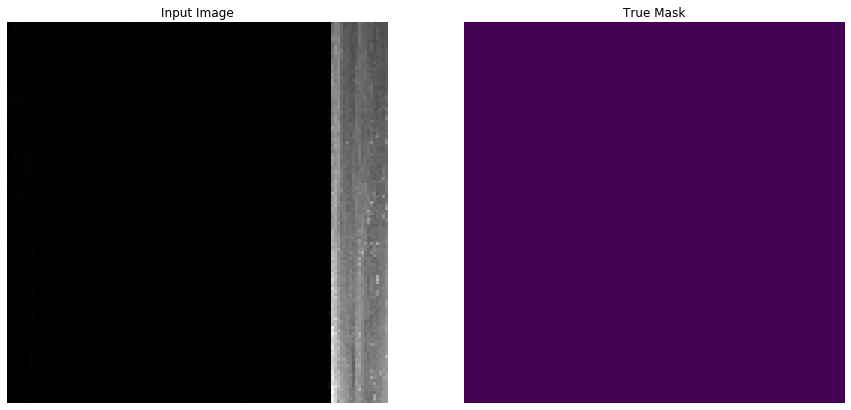

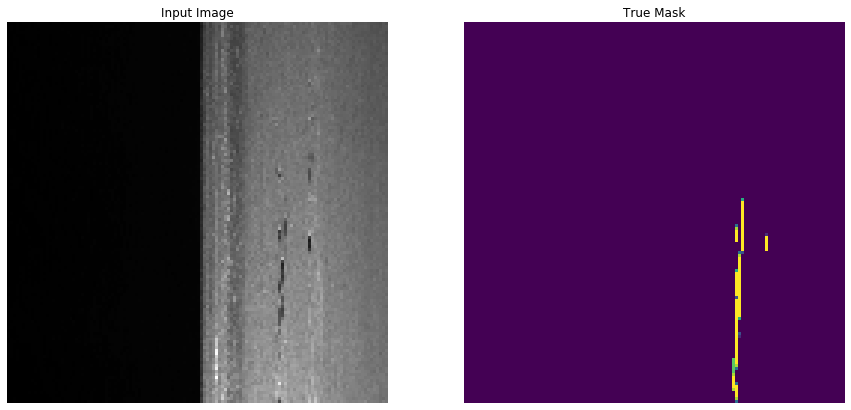

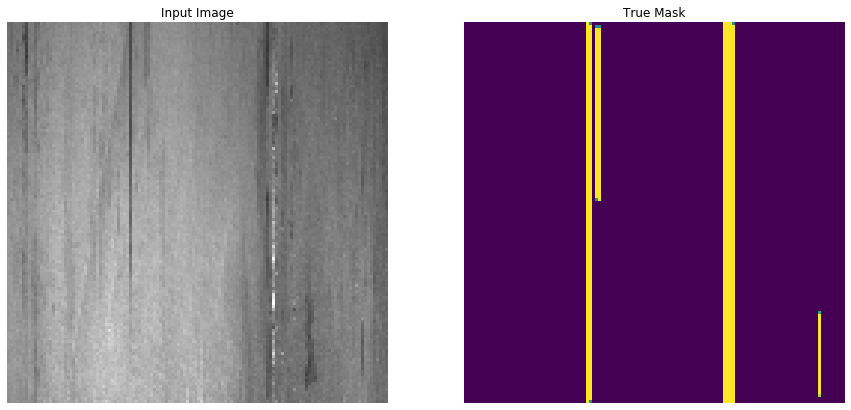

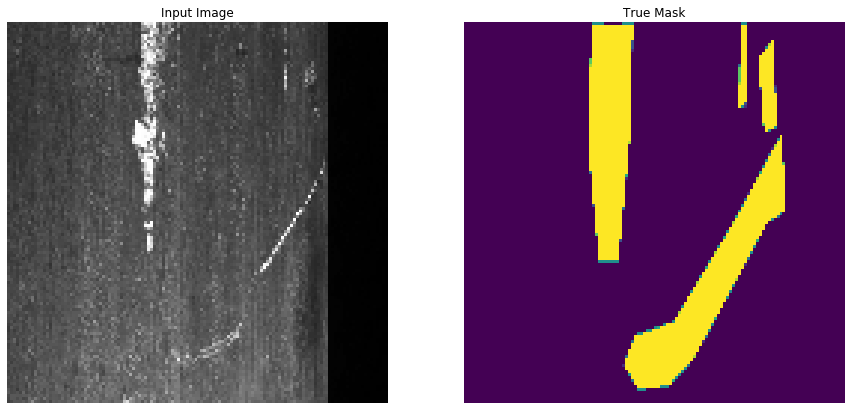

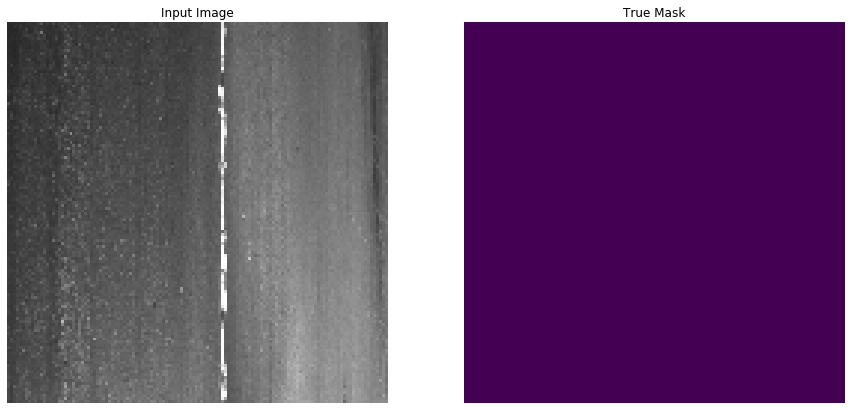

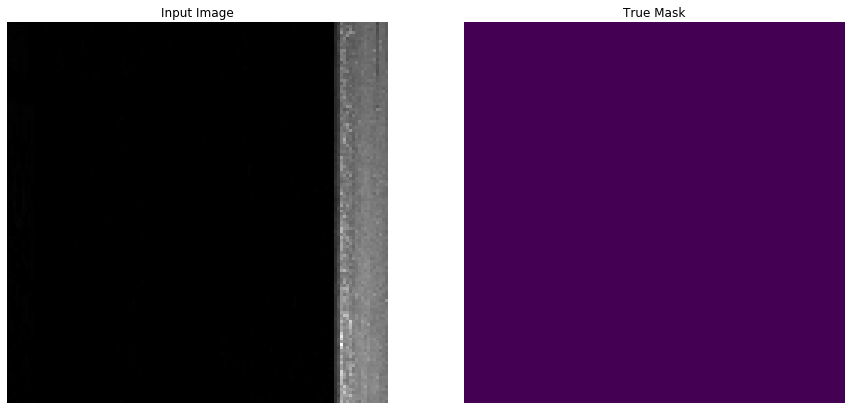

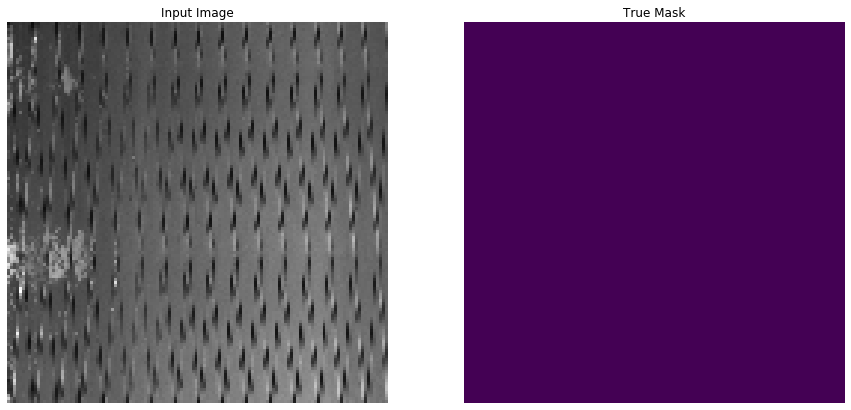

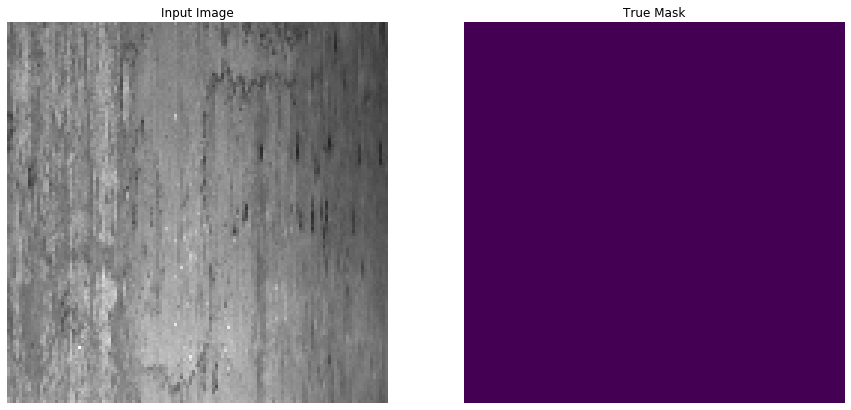

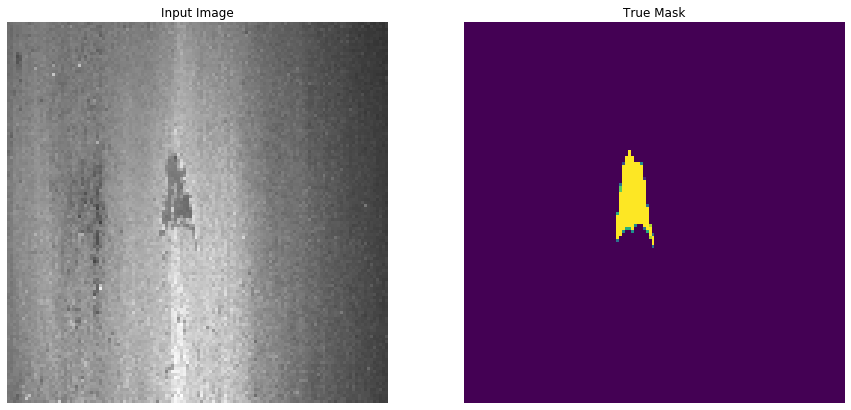

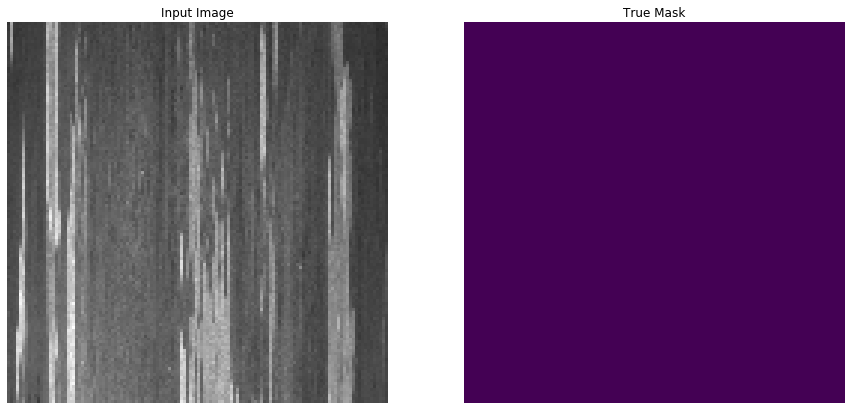

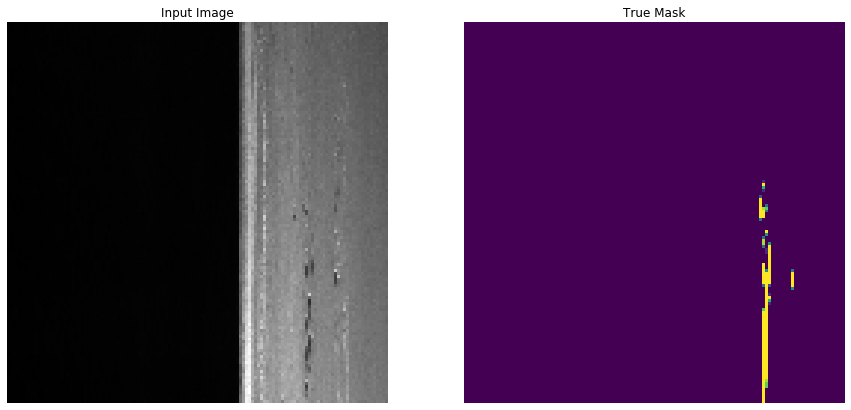

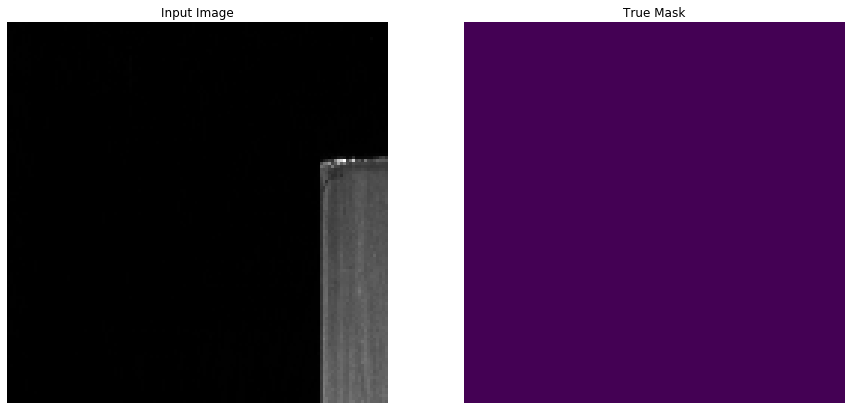

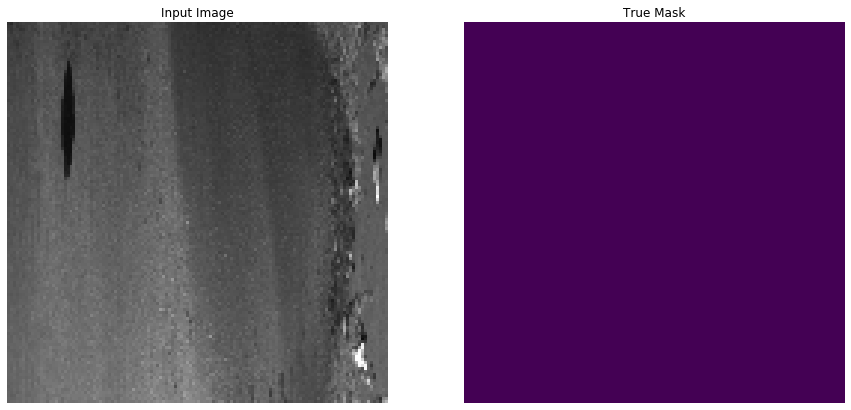

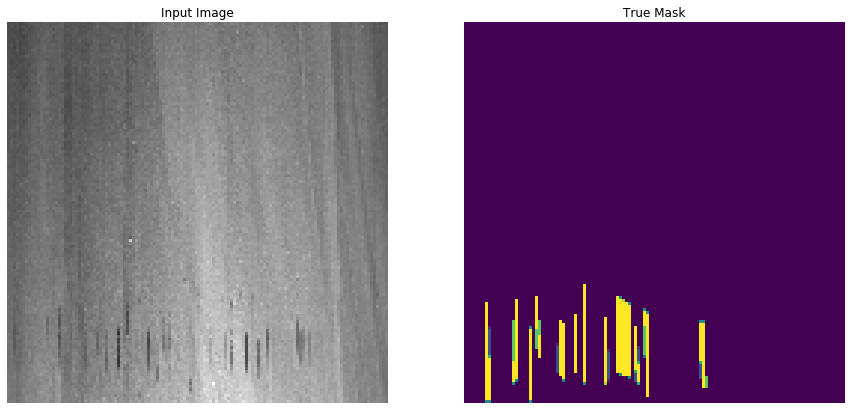

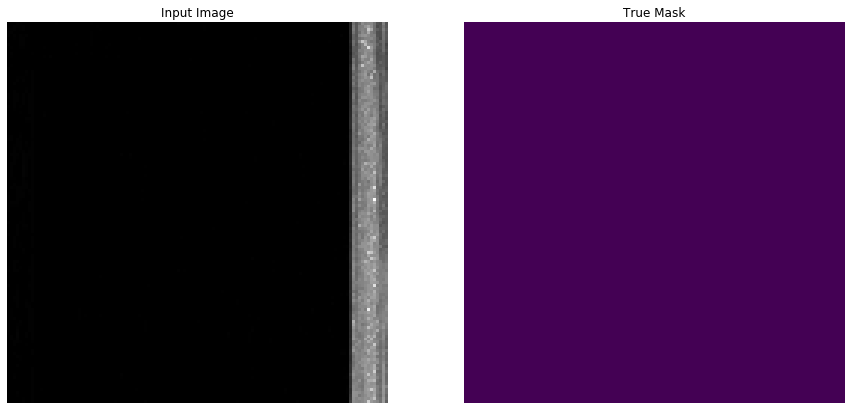

In [421]:
for image, mask in image_ds.take(20):
    sample_image, sample_mask = image, mask
    #print(sample_mask)
    display([sample_image, sample_mask])    


In [422]:
print(sample_mask[5,120])

tf.Tensor([0.], shape=(1,), dtype=float32)


In [423]:
np.unique(sample_mask.numpy())

array([0.], dtype=float32)

In [314]:
itemindex = np.where(sample_mask==[1.5])
itemindex


(array([0, 0, 0, 0]), array([30, 32, 41, 43]), array([0, 0, 0, 0]))

In [318]:
sample_mask[29, 127]

<tf.Tensor: id=16250, shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [319]:
import pix2pix

In [320]:
#define output channels - number of possible classes that one pixel can be assigned to (0 for no defect)
OUTPUT_CHANNELS = 4

In [328]:
img.shape

(256, 1600, 3)

In [329]:
base_model = tf.keras.applications.MobileNetV2(input_shape=sample_image.shape, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [330]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [331]:
def unet_model(output_channels, img_shape):

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
          output_channels, 3, strides=2,
          padding='same', activation='softmax')  #64x64 -> 128x128

    inputs = tf.keras.layers.Input(shape=img_shape)
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [332]:
model = unet_model(OUTPUT_CHANNELS, img_shape= sample_image.shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [333]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [438]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            print(shape(image, mask,create_mask(pred_mask) ))
            display([image[0].numpy().shape, mask[0].numpy().shape, create_mask(pred_mask).numpy().shape])
            #display([image, mask, pred_mask])

    else:
        p = model.predict(sample_image[tf.newaxis, ...])
        display([sample_image, sample_mask,p[0]])


In [357]:
#show predictions before training

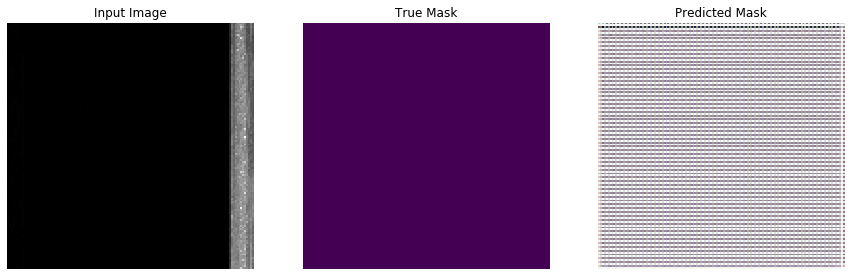

In [439]:
show_predictions()

In [353]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

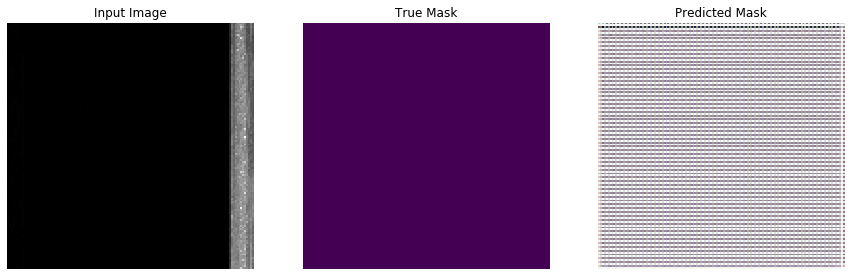


Sample Prediction after epoch 1

  1/186 [..............................] - ETA: 1:07

TypeError: 'NoneType' object is not callable

In [440]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 10

model_history = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dev_dataset,
                          callbacks=[DisplayCallback()])

In [43]:
dataset = tf.data.TFRecordDataset(filenames = get_filenames('tfrecord/'))

raw_example = next(iter( dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())


In [54]:
img_raw = parsed.features.feature['img_raw']
img_masks = parsed.features.feature['img_masks']

AttributeError: numpy